# **Submission Time Series**
Nama : Zaki Anwar Farizan

# Dataset Preparation

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download lsind18/daily-london-metal-fix-prices

  0% 0.00/136k [00:00<?, ?B/s]
100% 136k/136k [00:00<00:00, 48.3MB/s]


In [6]:
! unzip daily-london-metal-fix-prices

Archive:  daily-london-metal-fix-prices.zip
  inflating: londonfixes-current-clean_1990_.csv  


In [7]:
import pandas as pd

df = pd.read_csv('londonfixes-current-clean_1990_.csv')

In [8]:
df.head()

,Date,Gold AM Fix,Gold PM Fix,Silver Fix,Platinum AM Fix,Platinum PM Fix,Palladium AM Fix,Palladium PM Fix
0,2022-04-29,1915.45,1911.3,23.445,932.0,932.0,2303.0,2312.0
1,2022-04-28,1890.00,1888.5,23.160,929.0,915.0,2250.0,2249.0
2,2022-04-27,1896.15,1885.8,23.635,910.0,930.0,2179.0,2254.0
3,2022-04-26,1903.40,1904.6,23.770,922.0,915.0,2168.0,2186.0
4,2022-04-25,1918.70,1895.0,23.515,925.0,917.0,2303.0,2115.0


In [9]:
df.tail()

,Date,Gold AM Fix,Gold PM Fix,Silver Fix,Platinum AM Fix,Platinum PM Fix,Palladium AM Fix,Palladium PM Fix
8033,1990-04-06,380.35,377.70,5.1790,481.00,480.25,128.75,128.50
8034,1990-04-05,378.10,378.40,5.1475,481.75,481.85,128.40,127.75
8035,1990-04-04,374.25,374.25,5.0100,475.70,476.75,128.35,128.00
8036,1990-04-03,374.80,375.00,5.0010,475.80,477.25,128.35,128.50
8037,1990-04-02,368.00,368.40,4.9375,471.00,470.50,128.00,127.65


# Model Making

In [10]:
import numpy as np
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [11]:
# Check Null Value
df.isnull().sum()

Date                0
Gold AM Fix         0
Gold PM Fix         0
Silver Fix          0
Platinum AM Fix     0
Platinum PM Fix     0
Palladium AM Fix    0
Palladium PM Fix    0
dtype: int64

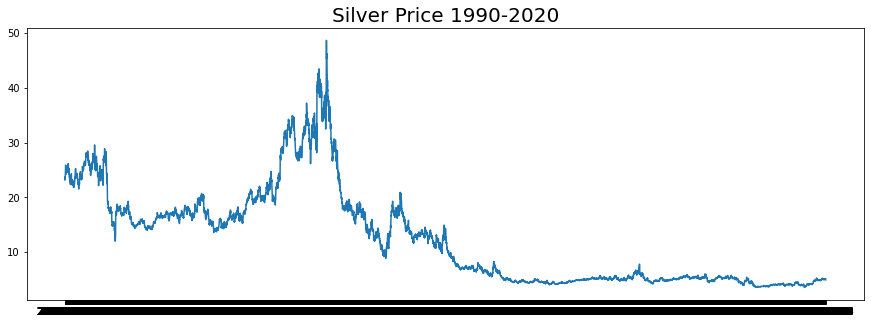

In [12]:
# Plotting Data
date = df['Date'].values
silver = df['Silver Fix'].values

plt.figure(figsize=(15,5))
plt.plot(date, silver)
plt.title('Silver Price 1990-2020',
          fontsize=20);

In [13]:
def windowed_dataset(series, window_size, batch_size, validation_split, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [14]:
train_set = windowed_dataset(silver, window_size=60, batch_size=100, validation_split=0.2, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dropout(rate=0.5),
  tf.keras.layers.Dense(1),
])

In [15]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


80/80 [==============================] - 15s 21ms/step - loss: 11.6935 - mae: 12.1935
Epoch 2/100
80/80 [==============================] - 2s 17ms/step - loss: 11.3110 - mae: 11.8110
Epoch 3/100
80/80 [==============================] - 2s 18ms/step - loss: 10.7393 - mae: 11.2392
Epoch 4/100
80/80 [==============================] - 2s 18ms/step - loss: 9.6464 - mae: 10.1334
Epoch 5/100
80/80 [==============================] - 2s 18ms/step - loss: 8.5933 - mae: 9.0648
Epoch 6/100
80/80 [==============================] - 2s 17ms/step - loss: 7.9722 - mae: 8.4468
Epoch 7/100
80/80 [==============================] - 2s 18ms/step - loss: 7.3868 - mae: 7.8656
Epoch 8/100
80/80 [==============================] - 2s 17ms/step - loss: 6.8926 - mae: 7.3735
Epoch 9/100
80/80 [==============================] - 1s 17ms/step - loss: 6.4221 - mae: 6.8990
Epoch 10/100
80/80 [==============================] - 2s 17ms/step - loss: 5.8193 - mae: 6.2960
Epoch 11/100
80/80 [==============================] -

In [16]:
threshold_mae = (df['Silver Fix'].max() - df['Silver Fix'].min()) * 10/100
threshold_mae

4.51525